# Problem Set 1

## Question 4

Continuing with the model (4), we numerically investigate the performance of various estimators designed for static panel data models, namely, $\hat\beta_{n,\mathrm{POLS}}$, $\hat\beta_{n,\mathrm{FE}}$, $\hat\beta_{n,\mathrm{FD}}$, and the first differenced estimator using $Y_{i,t-2}$ as instrument (i.e., the IV estimator of $\beta_0$ for the first-differenced equation using $Y_{i,t-2}$ as instrument). First, for each triple $(n,T,\beta_0)$ to be specified shortly, obtain the sample as follows.

1. Simulate $\alpha_i\overset{\mathrm{iid}}{\sim} N(0,1)$ and $\epsilon_i\overset{\mathrm{iid}}{\sim} N(0,1)$.

2. Generate $Y_{i0}$ according to $Y_{i0}=0.5\alpha_i + \epsilon_i$.

3. Generate $Y_{it}$ according to (4) with $V_{it}\overset{\mathrm{iid}}{\sim} N(0,1)$.

You may then compute the aforementioned estimators with the generated sample. Repeat the above steps $1000$ times, let $\hat\beta^{(r)}$ be the estimate based on the $i$th replication (for a particular estimator), and then the finite sample bias, standard error and root mean squared error are computed as follows:

\begin{align}
    \mathrm{Bias}(\hat\beta)&=\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)} - \beta_0~,\\
    \mathrm{SE}(\hat\beta)&=\{\frac{1}{1000}\sum_{r=1}^{1000}(\hat\beta^{(r)}-\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)})^2 \}^{1/2}~,\\
    \mathrm{RMSE} (\hat\beta) & = \{[\mathrm{Bias}(\hat\beta)]^2 + [\mathrm{SE}(\hat\beta)]^2\}^{1/2}~.
\end{align}

1. Let $n=100$ and $T=6$. Graph the bias, se and rmse of each estimator as functions of $\beta_0\in\{0,0.25,0.5,0.75,1\}$.

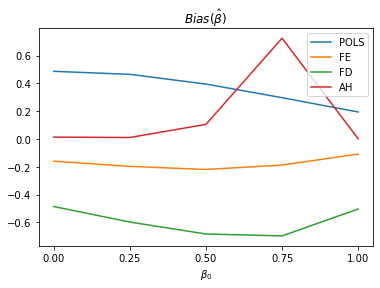

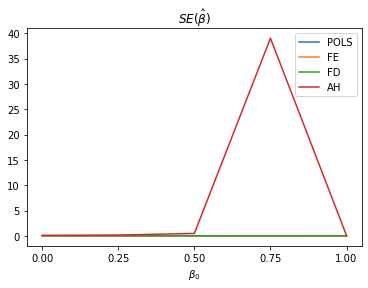

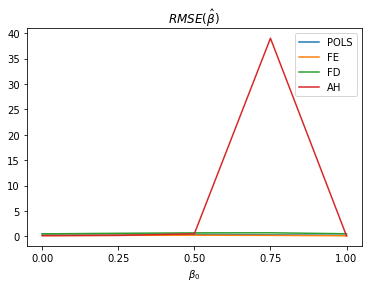

In [1]:
import numpy as np
import pandas as pd

#Settings
est_name = ["POLS", "FE", "FD", "AH"]
n, T = 100, 6
b_0 = [0, 0.25, 0.5, 0.75, 1]
mu, sigma = 0, 1
r = 1000

#Define the function for the simulation
def simulation(n, T):
    
    def bias(b_h_list, b_0):
        bias = np.array([x - b_0 for x in b_h_list]).mean()
        return bias

    def se(b_h_list):
        mean = np.array(b_h_list).mean()
        se = np.sqrt(np.array([(x - mean)**2 for x in b_h_list]).mean())
        return se

    def rmse(bias, se):
        rmse = np.sqrt(bias**2 + se**2)
        return rmse

    bias_results = {}
    se_results = {}
    rmse_results = {}

    for b_0_i in b_0:

        b_h_POLS_list = []
        b_h_fe_list = []
        b_h_fd_list = []
        b_h_ah_list = []

        for i in range(r):

            a_list = np.random.normal(mu, sigma, n) #for each individual
            e_list = np.random.normal(mu, sigma, n)

            y0 = np.array([0.5*a + e for a,e in zip(a_list, e_list)]) #Initial values for each individual

            y_t = [y0] #Insert the initial value
            for t in range(0, T):    #Total 7 periods including the initial period 0
              y_t.append(np.array(b_0_i * y_t[-1] + a_list + np.random.normal(mu, sigma, n)))

            y_tm1_df = pd.DataFrame(y_t)
            y_t_df = y_tm1_df.shift(-1)

            #POLS
            y_tm1_POLS = np.asmatrix( y_tm1_df[:-1].melt(value_name='yitm1').drop('variable', axis = 1) ) #melt to stack nT*1, t:0 to 5
            y_t_POLS = np.asmatrix( y_t_df[:-1].melt(value_name='yit').drop('variable', axis = 1) ) #t : 1 to 6
            b_h_POLS = (y_tm1_POLS.T @ y_tm1_POLS).I @ (y_tm1_POLS.T @ y_t_POLS)
            b_h_POLS_list.append(b_h_POLS.flat[0])

            #FE
            y_tm1_mean = y_tm1_df[:-1].mean() #Mean from t = 0 to 5
            y_t_mean = y_t_df[:-1].mean()  #Mean from t = 1 to 6

            y_tm1_dot = y_tm1_df[:-1] - y_tm1_mean
            y_t_dot = y_t_df[:-1] - y_t_mean 

            y_tm1_fe = np.asmatrix( y_tm1_dot.melt(value_name='yitm1').drop('variable', axis = 1) ) #melt to stack nT*1, t:0 to 5
            y_t_fe = np.asmatrix( y_t_dot.melt(value_name='yit').drop('variable', axis = 1) ) #t : 1 to 6
            b_h_fe = (y_tm1_fe.T @ y_tm1_fe).I @ (y_tm1_fe.T @ y_t_fe)
            b_h_fe_list.append(b_h_fe.flat[0])

            #FD
            y_tm1_delta = y_tm1_df[:-1] - y_tm1_df[:-1].shift(1)
            y_tm1_delta = y_tm1_delta[1:] #have to give up t = 0 i.e. t : 1 to 5
            y_t_delta = y_t_df[:-1] - y_t_df[:-1].shift(1)
            y_t_delta = y_t_delta[1:] #t: 2 to 6

            y_tm1_fd = np.asmatrix( y_tm1_delta.melt(value_name='yitm1').drop('variable', axis = 1) ) #melt to stack nT*1, t:1 to 5
            y_t_fd = np.asmatrix( y_t_delta.melt(value_name='yit').drop('variable', axis = 1) ) #t : 2 to 6
            b_h_fd = (y_tm1_fd.T @ y_tm1_fd).I @ (y_tm1_fd.T @ y_t_fd)
            b_h_fd_list.append(b_h_fd.flat[0])

            #AH
            y_tm2_delta_2 =  y_tm1_delta[:-1] #t: 1 to 4 
            y_tm1_delta_2 = y_tm1_delta[1:] #have to give up t = 1 i.e. t : 2 to 5
            y_t_delta_2 = y_t_delta[1:] #t: 3 to 6

            y_tm2_ah = np.asmatrix( y_tm2_delta_2.melt(value_name='yitm2').drop('variable', axis = 1) ) #melt to stack nT*1, t:1 to 4
            y_tm1_ah = np.asmatrix( y_tm1_delta_2.melt(value_name='yitm1').drop('variable', axis = 1) ) #melt to stack nT*1, t:2 to 5
            y_t_ah = np.asmatrix( y_t_delta_2.melt(value_name='yit').drop('variable', axis = 1) ) #t : 3 to 6
            b_h_ah = (y_tm2_ah.T @ y_tm1_ah).I @ (y_tm2_ah.T @ y_t_ah)
            b_h_ah_list.append(b_h_ah.flat[0])

        combined_b_h_list = [b_h_POLS_list, b_h_fe_list, b_h_fd_list, b_h_ah_list]

        for i in range(len(est_name)):

            name = est_name[i]

            if b_0_i == b_0[0]:
                bias_results[name] = []
                se_results[name] = []
                rmse_results[name] = []

            b_h_list = combined_b_h_list[i]
            bias_r = bias(b_h_list, b_0_i)
            se_r = se(b_h_list)
            rmse_r = rmse(bias_r, se_r)
            bias_results[name].append(bias_r)
            se_results[name].append(se_r)
            rmse_results[name].append(rmse_r)

    #Plotting the graph
    pd.DataFrame(bias_results, index = b_0).plot(title=r"$Bias(\hat{\beta})$",
                                                 xlabel = r"$\beta_{0}$", xticks = b_0)
    pd.DataFrame(se_results, index = b_0).plot(title = r"$SE(\hat{\beta})$",
                                               xlabel = r"$\beta_{0}$", xticks = b_0)
    pd.DataFrame(rmse_results, index = b_0).plot(title = r"$RMSE(\hat{\beta})$",
                                                 xlabel = r"$\beta_{0}$", xticks = b_0)
    
    
#Run the function on the first set of (n, T)
simulation(n = n, T = T)

2. Repeat part (1) with $(n,T)=(100,3)$ and $(n,T)=(100,9)$.

Result for (n, T) = (100, 3):


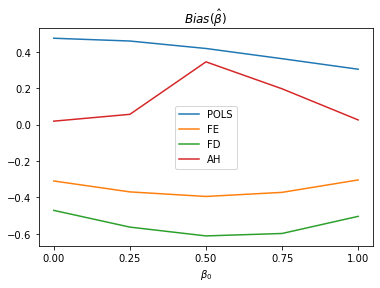

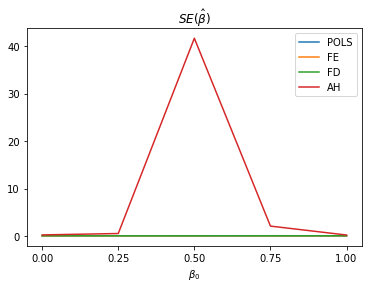

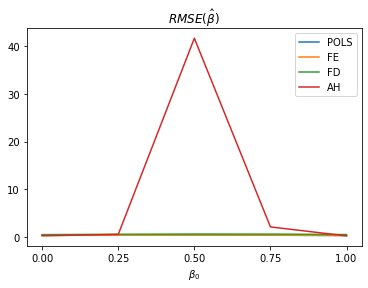

In [2]:
print("Result for (n, T) = (100, 3):")
simulation(n = 100, T = 3)

Result for (n, T) = (100, 9):


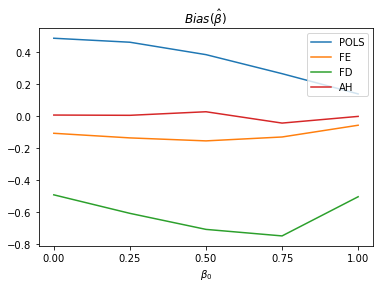

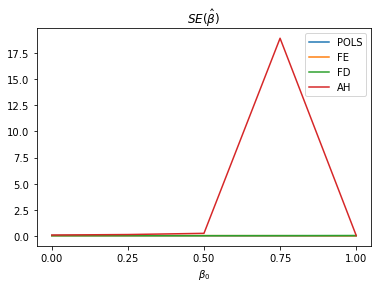

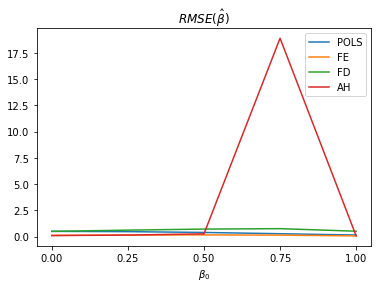

In [3]:
print("Result for (n, T) = (100, 9):")
simulation(n = 100, T = 9)

## Question 5

Do Exercise 17.17(a) in Hansen (2022). You will need the formula (17.93) in Hansen (2022) (see the pdf file in Canvas) for the clustered standard errors.

Question: Use the datafile ``Invest1993`` on the textbook webpage. You will be estimating the panel AR(1) $D_{it} = \alpha D_{i,t-1} + u_i + \varepsilon_{it}$ for $D = debt/assets$ (this is $debta$ in the datafile). See the description file for definitions.

(a) Estimate the model using Arellano-Bond two step GMM with clustered standard errors.

In [37]:
#Arellano-Bond two step GMM with clustered se

raw_data = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/Invest1993.dta")


In [42]:
raw_data[["cusip","year", "debta"]]

,cusip,year,debta
0,32,1970,0.04644
1,32,1971,0.66158
2,32,1972,0.57597
3,32,1973,0.51771
4,32,1974,0.54761
...,...,...,...
27561,989845,1987,-0.00855
27562,989845,1988,0.00000
27563,989845,1989,0.00000
27564,989845,1990,0.17137
